In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import itertools
import random
import seaborn as sns
from itertools import product
import scipy.stats as stats
import re
import itertools
from scipy.stats import norm
from Step2.preprocessing.BA_params import *
from Step2.preprocessing.load_train_param import *
from Step2.preprocessing.filters import *
from Step2.LR.lr import *
from Step2.LR.trials import *
from Step2.LR.llr_prediction import *
from Step2.LR.performance import cllr, min_cllr
from sklearn.metrics.pairwise import cosine_similarity
import shap
import pickle

In [2]:
path="/xvectors/voxceleb1_nosil/xvectors.txt"
#Load parameters
typ_path="data/typ_clean.txt"
dout_path="data/dout_clean.txt"

In [3]:
utterances, vectors = readVectors(path)
xvectors = np.array(vectors).astype('float64')
BA = ['BA' + str(i) for i in range(xvectors.shape[1])]
df = pd.DataFrame(xvectors, columns=BA)
df=todelete(df,BA)
df

0.0%
10.0%
20.0%
30.0%
40.0%
50.0%
60.0%
70.0%
80.0%
90.0%
100.0%


,BA2,BA3,BA4,BA5,BA8,BA9,BA10,BA11,BA12,BA13,...,BA244,BA245,BA247,BA248,BA250,BA251,BA252,BA253,BA254,BA255
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153511,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
153512,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0
153513,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
153514,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [4]:
typ,dout=load_filter_soft(typ_path,dout_path)
df=df[list(typ.keys())]
BA_test=list(typ.keys())

In [5]:
utt={}
for (idx,row) in df.iterrows():
    utt[f"utt{idx}"]=dict(row)

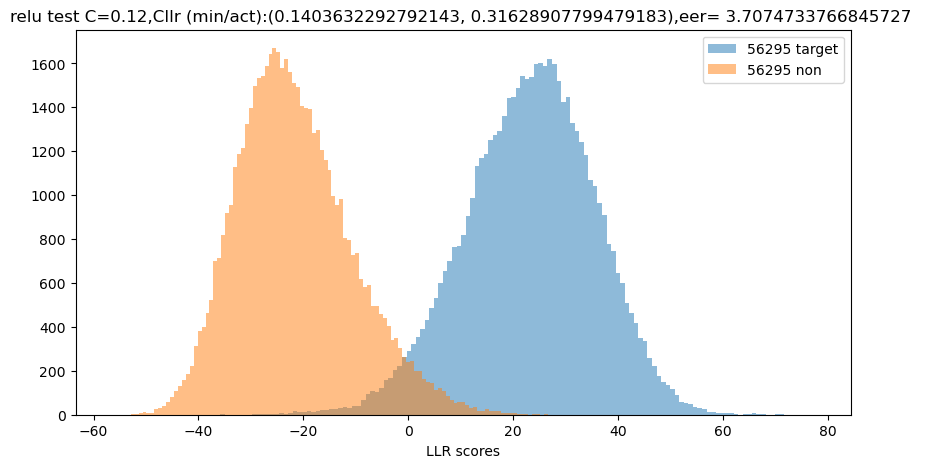

In [6]:
non,tar= load_trials()
LLR_target,LLR_non,list_eer,list_cllr_min,list_cllr_act,list_Din=LR_framework(dout,typ,utt,tar,non,[0.12])
plt.show()

In [7]:
utt_llr_tar,llr_type_tar=partial_lr_analysis(tar, BA_test,utt,typ, dout, prob_dropin=0.12)
utt_llr_non,llr_type_non=partial_lr_analysis(non,BA_test,utt,typ, dout, prob_dropin=0.12)
df_llr_tar=stats(utt_llr_tar,LLR_target)
df_llr_non=stats(utt_llr_non,LLR_non)

In [11]:
BA_tar={}
for ba in BA_test:
    ba_target=[]
    for i1,i2 in tar:
        ba_target.append((int(utt[i1][ba]),int(utt[i2][ba])))
    BA_tar[ba]=ba_target
#composition of each utterance in the non couples
BA_non={}
for ba in BA_test:
    ba_non=[]
    for i1,i2 in non:
        ba_non.append((int(utt[i1][ba]),int(utt[i2][ba])))
    BA_non[ba]=ba_non
df_BA_non=pd.DataFrame(BA_non)
df_non=pd.DataFrame(pd.Series(non),columns=["non"])
df_non=pd.concat([df_non,df_BA_non],axis=1)
df_BA=pd.DataFrame(BA_tar)
df_tar=pd.DataFrame(pd.Series(tar),columns=["target"])
df_tar=pd.concat([df_tar,df_BA],axis=1)
df_tar["scores"]=LLR_target
df_non["scores"]=LLR_non

In [12]:
scores_BA={}
for b in BA_test:
    if b in BA_test:
        scores_BA[b]={"00":0,"01":0,"10":0,"11":0}
        for i in set(df_llr_tar[b]):
            index=df_llr_tar[df_llr_tar[b]==i].index[0]
            if df_tar[b].loc[index]==(0, 0):
                scores_BA[b]["00"]=i
            elif df_tar[b].loc[index]==(1, 0):
                scores_BA[b]["10"]=i
            elif df_tar[b].loc[index]==(0, 1):
                scores_BA[b]["01"]=i
            else:
                scores_BA[b]["11"]=i

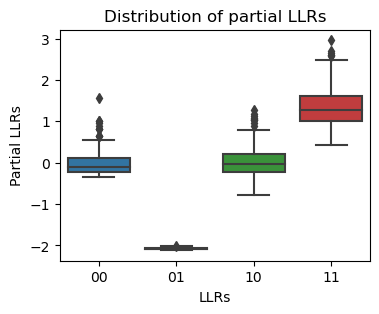

In [13]:
scores_df=pd.DataFrame.from_dict(scores_BA).T
plt.figure(figsize=(4,3))
sns.boxplot(data=scores_df, orient="v")
plt.title("Distribution of partial LLRs")
plt.xlabel("LLRs")
plt.ylabel("Partial LLRs")
plt.show()

In [14]:
scores_BA_df=pd.DataFrame()
scores_BA_df["BA"]=typ.keys()
scores_BA_df["Typicality"]=typ.values()
scores_BA_df["Dropout"]=dout.values()
scores_BA_df=scores_BA_df.sort_values("Typicality")

In [15]:
scores_BA_df

,BA,Typicality,Dropout
5,BA9,0.156562,0.458987
19,BA25,0.219734,0.790866
71,BA85,0.227625,0.731334
112,BA144,0.235979,0.730976
44,BA54,0.257014,0.733017
...,...,...,...
152,BA191,0.931152,0.567703
148,BA187,0.952525,0.609464
136,BA174,0.965269,0.518008
180,BA224,0.965597,0.443862
